In [1]:
#delfos copy for pka prediction
import torch
from torch import nn
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit import Chem
from numpy import genfromtxt
import numpy as np
import cProfile

RDKit WARNING: [14:47:38] Enabling RDKit 2019.09.3 jupyter extensions
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#step 1: define solvent X and solute Y using mol2vec but don't add the substructures!!
#step 2: run RNN in both directions on each molecule, then concatenate forward;reverse to get H and G
#step 3: feed H and G into attention layer, generate attention alignment matrix, create contexts P and Q
#step 4: maxpool H;P and G;Q into 2D feature vectors
#step 5: create flattened input u;v and feed into linear layer

In [ ]:
#modified sentence2vec function to return lists of word vectors
def sentences2vecs(sentences, model, unseen=None):
    """Generate vectors for each word in a sentence sentence (list) in a list of sentences.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032
    Returns
    -------
    list of arrays, each sentence -> array of word vectors
    """
    keys = set(model.wv.key_to_index)
    bigveclist = []
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        veclist = []
        if unseen:
            veclist.append([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence])
        else:
            veclist.append([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys])
        vecarray = np.concatenate(veclist, axis=1)
        vectensor = torch.Tensor(vecarray)
        bigveclist.append(vectensor)
    return bigveclist

In [4]:
#step 1: mol2vec embedding

data = pd.read_csv('data/ETMdata.csv')

#mol2vec model
mol2vec_model = word2vec.Word2Vec.load('models/model_300dim.pkl')

#create mol type
data['sol_mol'] = data.apply(lambda x: Chem.MolFromSmiles(x['solute']), axis=1)
data['solv_mol'] = data.apply(lambda x: Chem.MolFromSmiles(x['solvent']), axis=1)

#remove invalid smiles
#data.replace("", float("NaN"), inplace=True)
#data.dropna(subset = ['mol'], inplace=True)
#print(data)

#create sentences
data['sol_sentence'] = data.apply(lambda x: mol2alt_sentence(x['sol_mol'],1), axis=1)
data['solv_sentence'] = data.apply(lambda x: mol2alt_sentence(x['solv_mol'],1), axis=1)

targets = torch.Tensor(data['pka'])
sol_data = sentences2vecs(data['sol_sentence'], mol2vec_model, unseen='UNK')
solv_data = sentences2vecs(data['solv_sentence'], mol2vec_model, unseen='UNK')

In [12]:
#from torch.nn.utils.rnn import pack_sequence
#X = pack_sequence(X,enforce_sorted = False)
##TODO BATCHING VARIABLE SEQUENCE LENGTHS

In [15]:
def alpha(G,H):
    alpha = torch.exp(H@torch.t(G))
    norm = torch.sum(alpha, dim=1)
    norm = torch.pow(norm, -1)
    alpha = alpha * norm[:, None]
    return alpha

def att(G,H):
    Q = alpha(G,H)@G
    inH = torch.cat((H,Q),1)
    return inH

In [18]:
# model definition
epochs = 10
n_features = 300
n_hidden = 100

class maxpool(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d((L,2), stride=2)
    def forward(self, X):
        return self.maxpool(X)

class dnet(nn.Module):
    def __init__(self, n_features, D, FF):
        super(dnet, self).__init__()
    
        self.biLSTM_X = nn.LSTM(n_features, D, bidirectional=True)
        self.biLSTM_Y = nn.LSTM(n_features, D, bidirectional=True)
        
        self.FF = nn.Linear(4*D, FF)
        self.out = nn.Linear(FF, 1)
    
    def forward(self,X,Y):
        N = X.data.shape[0]
        M = Y.data.shape[0]
        
        #turn input list of vec into correct shape
        X = X.view(X.data.shape[0],1,X.data.shape[1]) #N rows
        Y = Y.view(Y.data.shape[0],1,Y.data.shape[1]) #M rows
        
        #biLSTM to get hidden states
        H, hcX = self.biLSTM_X(X, None) #Nx1x2D matrix
        G, hcY = self.biLSTM_Y(Y, None) #Mx1x2D matrix
        
        #contexts
        inG = att(H[:,0,:],G[:,0,:]) #Nx4D
        inH = att(G[:,0,:],H[:,0,:]) #Mx4D
        
        #maxpool concatenated tensors
        maxpool_X = maxpool(N)
        maxpool_Y = maxpool(M)
        u = maxpool_X(inH.view(1,inH.data.shape[0],inH.data.shape[1]))  #1x1x2D
        v = maxpool_Y(inG.view(1,inG.data.shape[0],inG.data.shape[1]))  #1x1x2D
        
        #feed forward neural network
        NN = torch.cat((u,v),2)
        NN = self.FF(NN)
        NN = nn.functional.relu(NN)
        output = self.out(NN)
        return output

dmodel = dnet(300,150,2000)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(dmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

In [268]:
# model definition, 3D maxpool
epochs = 10
n_features = 300
n_hidden = 100

class maxpool(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d((L,1,2), stride=1)
    def forward(self, X):
        return self.maxpool(X)
    
def att(G,H):
    Q = alpha(G,H)@G
    inH = torch.stack([H,Q],2)
    return inH

class dnet(nn.Module):
    def __init__(self, n_features, D, FF):
        super(dnet, self).__init__()
    
        self.biLSTM_X = nn.LSTM(n_features, D, bidirectional=True)
        self.biLSTM_Y = nn.LSTM(n_features, D, bidirectional=True)
        
        self.FF = nn.Linear(4*D, FF)
        self.out = nn.Linear(FF, 1)
    
    def forward(self,X,Y):
        N = X.data.shape[0]
        M = Y.data.shape[0]
        
        #turn input list of vec into correct shape
        X = X.view(X.data.shape[0],1,X.data.shape[1]) #N rows
        Y = Y.view(Y.data.shape[0],1,Y.data.shape[1]) #M rows
        
        #biLSTM to get hidden states
        H, hcX = self.biLSTM_X(X, None) #Nx1x2D matrix
        G, hcY = self.biLSTM_Y(Y, None) #Mx1x2D matrix
        
        #contexts
        inG = att(H[:,0,:],G[:,0,:]) #Nx4D
        inH = att(G[:,0,:],H[:,0,:]) #Mx4D
        
        #maxpool concatenated tensors
        maxpool_X = maxpool(N)
        maxpool_Y = maxpool(M)
        u = maxpool_X(inH.view(1,inH.data.shape[0],inH.data.shape[1],inH.data.shape[2]))  #1x1x2D
        v = maxpool_Y(inG.view(1,inG.data.shape[0],inG.data.shape[1],inG.data.shape[2]))  #1x1x2D
        
        #feed forward neural network
        NN = torch.cat((u,v),2).view(1,1,600)
        NN = self.FF(NN)
        NN = nn.functional.relu(NN)
        output = self.out(NN)
        return output

dmodel = dnet(300,150,2000)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(dmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step :  0 loss :  53.20024871826172
step :  1 loss :  45.00778579711914
step :  2 loss :  37.44200134277344
step :  3 loss :  32.07887268066406
step :  4 loss :  29.65617561340332
step :  5 loss :  30.462108612060547
step :  6 loss :  36.53616714477539
step :  7 loss :  42.295860290527344
step :  8 loss :  49.38310623168945
step :  9 loss :  43.633697509765625


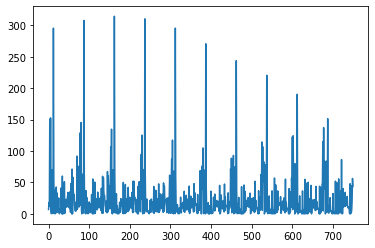

In [21]:
epochs = 10
n_features = 300
n_hidden = 100
losslist = []
for t in range(epochs):
    for b in range(len(sol_data)):
        solute = sol_data[b]
        solvent = solv_data[0]
        target = targets[b]  
        output = dmodel(solute,solvent) 
        loss = criterion(output, target)  
        losslist.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('step : ' , t , 'loss : ' , loss.item())
    
import matplotlib.pyplot as plt
plt.plot(losslist)

In [210]:
cProfile.run("dmodel(X[2],Y[0])", sort = "cumtime")

         526 function calls (518 primitive calls) in 0.078 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.078    0.078 {built-in method builtins.exec}
        1    0.005    0.005    0.078    0.078 <string>:1(<module>)
      9/1    0.000    0.000    0.073    0.073 module.py:715(_call_impl)
        1    0.000    0.000    0.073    0.073 <ipython-input-208-c9036915f170>:23(forward)
        2    0.000    0.000    0.070    0.035 rnn.py:555(forward)
        2    0.069    0.035    0.069    0.035 {built-in method lstm}
        2    0.000    0.000    0.002    0.001 <ipython-input-207-127204d06c41>:8(att)
        2    0.001    0.000    0.001    0.001 <ipython-input-207-127204d06c41>:1(alpha)
        2    0.001    0.000    0.001    0.000 {built-in method exp}
        2    0.000    0.000    0.000    0.000 <ipython-input-208-c9036915f170>:10(forward)
        2    0.000    0.000    0.000    0.000 poolin

In [179]:
# batch model definition
epochs = 10
n_features = 300
n_hidden = 100
batch_size = 32

class maxpool(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d((L,2), stride=2)
    def forward(self, X):
        return self.maxpool(X)

class dnet(nn.Module):
    def __init__(self, n_features, D, FF):
        super(dnet, self).__init__()
    
        self.biLSTM_X = nn.LSTM(n_features, D, bidirectional=True)
        self.biLSTM_Y = nn.LSTM(n_features, D, bidirectional=True)
        
        self.FF = nn.Linear(4*D, FF)
        self.out = nn.Linear(FF, 1)
    
    def forward(self,X,Y):
        N = X.data.shape[0]
        M = Y.data.shape[0]
        
        #turn input list of vec into correct shape
        X = X.view(X.data.shape[0],1,X.data.shape[1]) #N rows
        Y = Y.view(Y.data.shape[0],1,Y.data.shape[1]) #M rows
        
        #biLSTM to get hidden states
        H, hcX = self.biLSTM_X(X, None) #NxBx2D matrix
        G, hcY = self.biLSTM_Y(Y, None) #MxBx2D matrix
        
        inG = torch.Tensor([att(G[:,b,:],H[:,b,:]) for b in range(batch_size)])
        inH = torch.Tensor([att(H[:,b,:],G[:,b,:]) for b in range(batch_size)])
        
        #maxpool concatenated tensors
        maxpool_X = maxpool(N)
        maxpool_Y = maxpool(M)
        u = maxpool_X(inH)  #1x1x2D
        v = maxpool_Y(inG)  #1x1x2D
        
        #feed forward neural network
        NN = torch.cat((u,v),2)
        NN = self.FF(NN)
        NN = nn.functional.relu(NN)
        output = self.out(NN)
        return output

dmodel = dnet(300,150,2000)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(dmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

In [ ]:
class SolvDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [216]:
from torch.utils.data import TensorDataset, DataLoader

def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    lengths = torch.tensor([ t.shape[0] for t in batch ]).to(device)
    ## padd
    batch = [ torch.Tensor(t).to(device) for t in batch ]
    batch = torch.nn.utils.rnn.pad_sequence(batch)
    ## compute mask
    mask = (batch != 0).to(device)
    return batch, lengths, mask

loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn = collate_fn_padd)

for batch_idx, (x, t) in enumerate(loader):
    print(x.shape, t.shape)

AttributeError: 'list' object has no attribute 'size'

In [ ]:
for t in range(epochs):
    for b in range(len(X)):
        solute = X[b]
        solvent = Y[0]
        target = targets[b]  

        output = dmodel(solute,solvent) 
        print(output)
        loss = criterion(output, target)  
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    print('step : ' , t , 'loss : ' , loss.item())